In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm

import sys

sys.path.append("../src/")

from benchmarks import damped_sine_wave, hermite_polynomial, mackey_glass
from metrics import mae, rmse, mape, smape, print_metrics
from network import Network
from utils import create_time_series

## Functions to approximate

### Damped Sine Wave

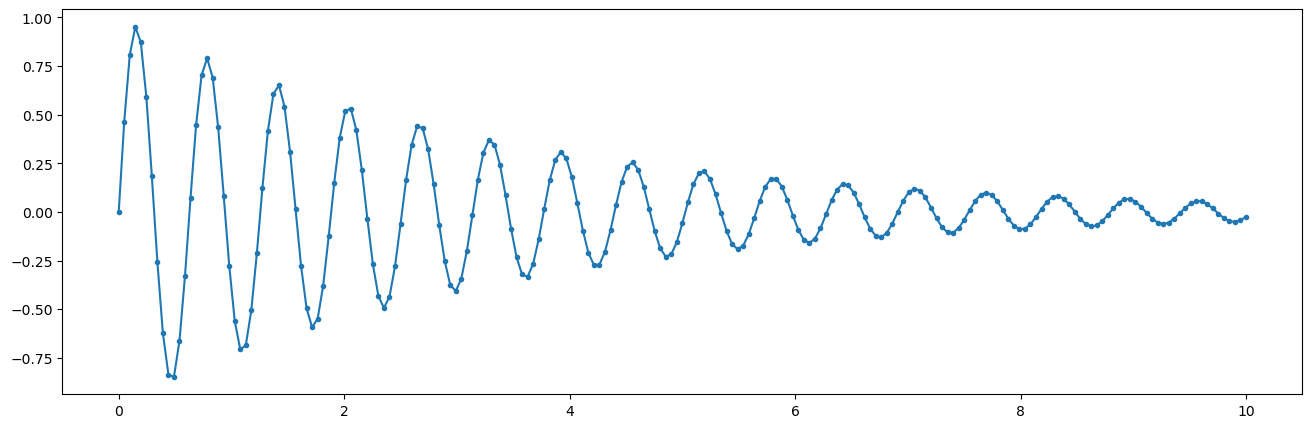

In [2]:
x = np.linspace(0, 10, 205)
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, damped_sine_wave(x), ".-")
plt.show()

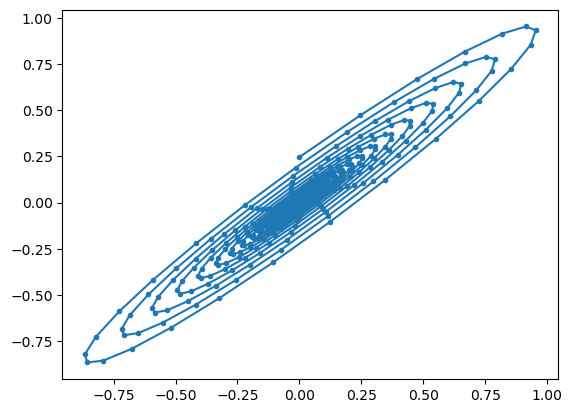

In [3]:
x, y = create_time_series(damped_sine_wave(np.linspace(0, 10, 400)), look_back=1)
plt.plot(x, y, ".-")
plt.show()

### Hermite Polynomial

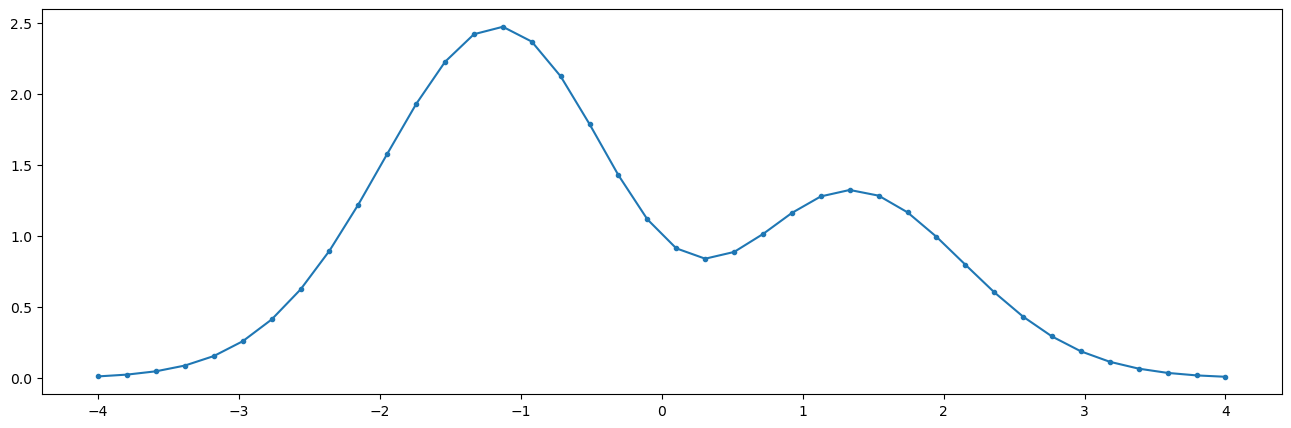

In [4]:
x = np.linspace(-4, 4, 40)
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, hermite_polynomial(x), ".-")
plt.show()

### Mackey-Glass

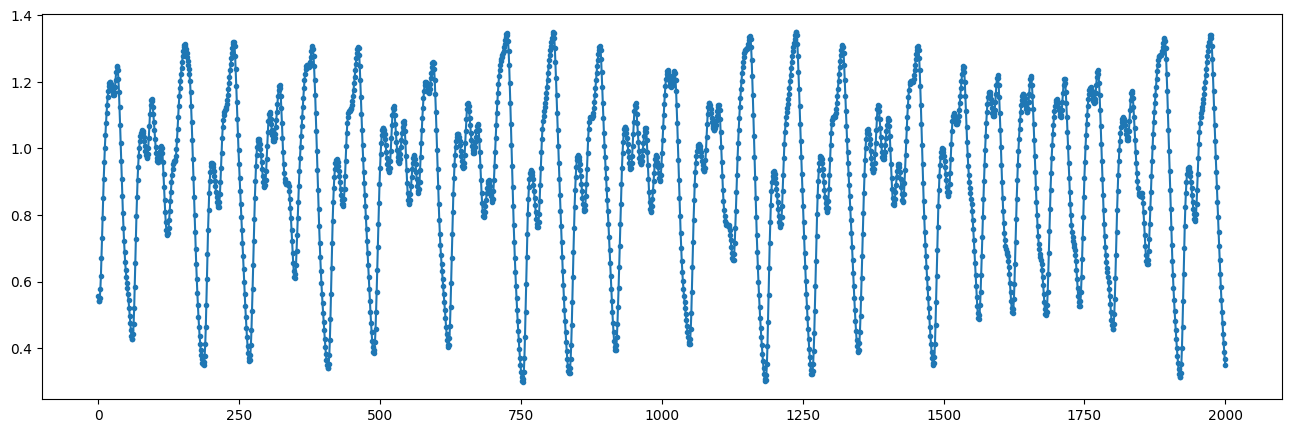

In [5]:
x = np.linspace(0, 2000, 2000)
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, mackey_glass(length=2000, x0=1, sample=1), ".-")
plt.show()

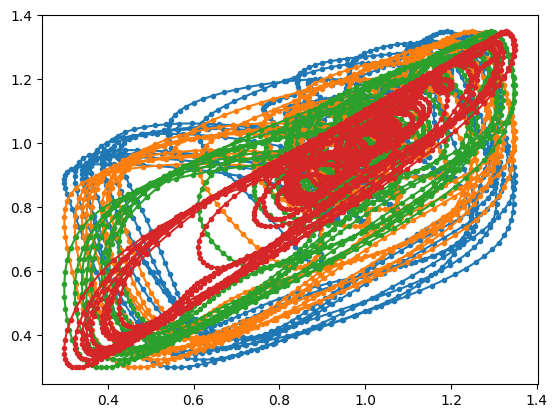

In [6]:
x, y = create_time_series(mackey_glass(length=2000, x0=1), look_back=4, steps=6)
plt.plot(x, y, ".-")
plt.show()

## Learning process

### Hermite Polynomial

In [10]:
dataset = pd.DataFrame()
dataset["x"] = np.linspace(-4, 4, 40)
dataset["y_true"] = hermite_polynomial(np.linspace(-4, 4, 40))
dataset["y_train"] = np.nan

net = Network(
    input_size=1,
    output_size=1,
    error_threshold=0.02,
    distance_threshold=1.0,
    learning_rate=0.1,
    overlap_factor=0.8,
    activation_threshold=0.02,
    pruning_window=40,
)

history = pd.DataFrame()
for epoch in tqdm(range(100)):
    # perform learning
    for i, row in dataset.iterrows():
        dataset.loc[i, "y_train"] = net.learning(
            x=np.array([row["x"]]),
            y=np.array([row["y_true"]]),
        )
    # save history
    history = pd.concat(
        [
            history,
            pd.DataFrame(
                {
                    "d": [net._d_th],
                    "e": [net._e_th],
                    "n": [len(net._hidden_nodes)],
                    "mae": [mae(dataset["y_true"], dataset["y_train"])],
                    "rmse": [rmse(dataset["y_true"], dataset["y_train"])],
                    "mape": [mape(dataset["y_true"], dataset["y_train"])],
                    "smape": [smape(dataset["y_true"], dataset["y_train"])],
                }
            ),
        ],
        ignore_index=True,
    )

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


Final number of neurons: 49
MAE: 0.0110 hPa
RMSE: 0.0173 hPa
SMAPE: 4.4700 %


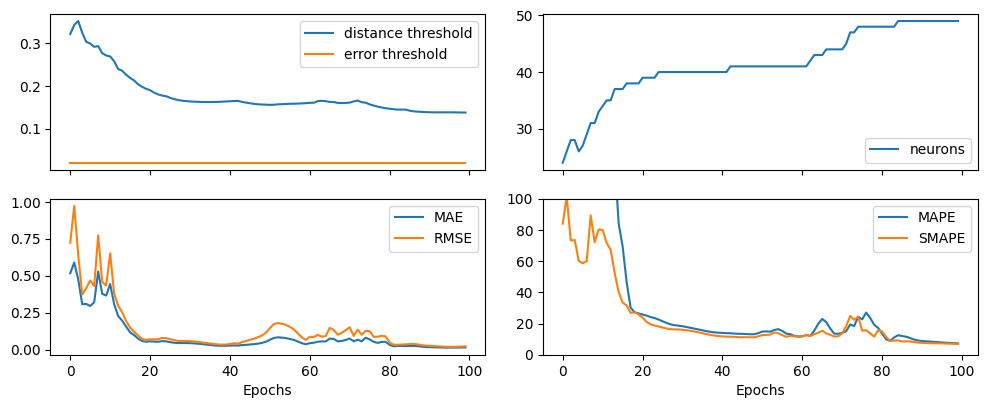

In [11]:
print("Final number of neurons:", len(net._hidden_nodes))

y_test = np.array([net.inference(np.array([x])) for x in dataset["x"]])
print_metrics(dataset["y_true"], y_test)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
fig.tight_layout()
ax1.plot(history.index, history["d"], label="distance threshold")
ax1.plot(history.index, history["e"], label="error threshold")
ax1.legend(loc="upper right")
ax2.plot(history.index, history["n"], label="neurons")
ax2.legend(loc="lower right")
ax3.plot(history.index, history["mae"], label="MAE")
ax3.plot(history.index, history["rmse"], label="RMSE")
ax3.set_xlabel("Epochs")
ax3.legend(loc="upper right")
ax4.plot(history.index, history["mape"], label="MAPE")
ax4.plot(history.index, history["smape"], label="SMAPE")
ax4.set_xlabel("Epochs")
ax4.set_ylim(0, 100)
ax4.legend(loc="upper right")
plt.show()

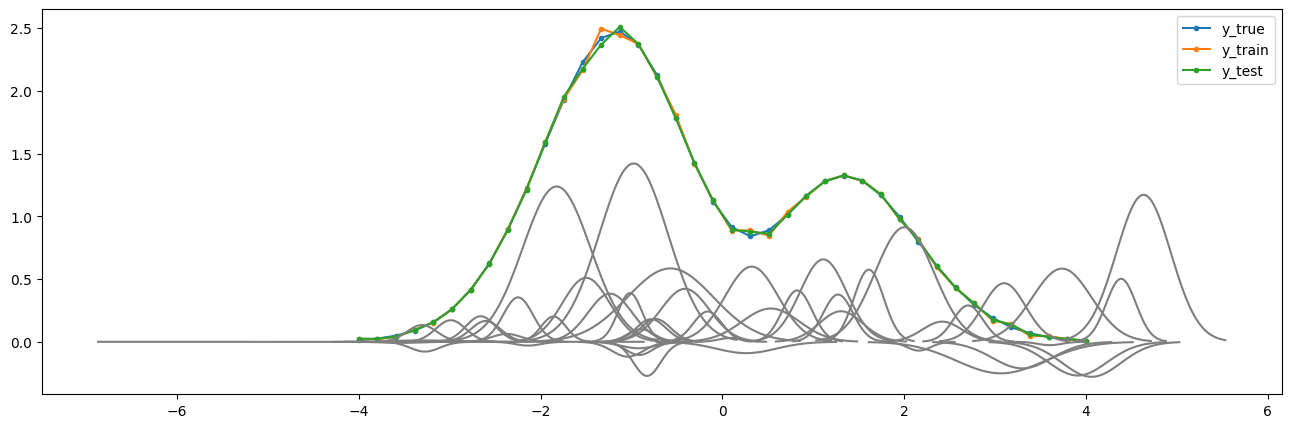

In [13]:
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(dataset["x"], dataset["y_true"], ".-", label="y_true")
ax.plot(dataset["x"], dataset["y_train"], ".-", label="y_train")
ax.plot(dataset["x"], y_test, ".-", label="y_test")
for i, n in enumerate(net._hidden_nodes):
    c, r = n.center, n.radius
    norm = stats.norm.pdf(np.linspace(c - 3 * r, c + 3 * r, 100), c, r)
    norm /= np.max(norm)
    ax.plot(
        np.linspace(c - 3 * r, c + 3 * r, 100),
        net._weights[0, 0] + net._weights[0, i] * norm,
        color="tab:gray",
    )
ax.legend()
plt.show()

### Damped Sine Wave

In [2]:
dataset = pd.DataFrame()
dataset["x"] = np.linspace(0, 5, 200)
dataset["y_true"] = damped_sine_wave(np.linspace(0, 5, 200))
dataset["y_train"] = np.nan

net = Network(
    input_size=1,
    output_size=1,
    error_threshold=0.01,
    distance_threshold=0.01,
    average_window=None,
    learning_rate=0.15,
    overlap_factor=0.8,
)

history = pd.DataFrame()
for epoch in tqdm(range(100)):
    # shuffle dataset randomly
    # dataset = dataset.sample(frac=1)

    # perform learning
    for i, row in dataset.iterrows():
        dataset.loc[i, "y_train"] = net.learning(
            x=np.array([row["x"]]),
            y=np.array([row["y_true"]]),
        )
    # save history
    history = pd.concat(
        [
            history,
            pd.DataFrame(
                {
                    "d": [net._d_th],
                    "e": [net._e_th],
                    "n": [len(net._hidden_nodes)],
                    "mae": [mae(dataset["y_true"], dataset["y_train"])],
                    "rmse": [rmse(dataset["y_true"], dataset["y_train"])],
                    "mape": [mape(dataset["y_true"], dataset["y_train"])],
                    "smape": [smape(dataset["y_true"], dataset["y_train"])],
                }
            ),
        ],
        ignore_index=True,
    )

# sort dataset by x
# dataset.sort_index(inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Final number of neurons: 85
MAE: 0.2618 hPa
RMSE: 0.3722 hPa
SMAPE: 98.8426 %


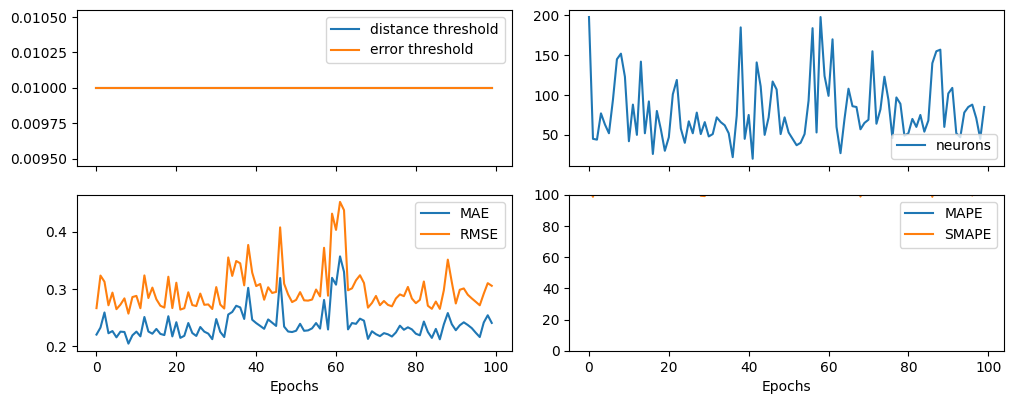

In [3]:
print("Final number of neurons:", len(net._hidden_nodes))

y_test = np.array([net.inference(np.array([x])) for x in dataset["x"]])
print_metrics(dataset["y_true"], y_test)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
fig.tight_layout()
ax1.plot(history.index, history["d"], label="distance threshold")
ax1.plot(history.index, history["e"], label="error threshold")
ax1.legend(loc="upper right")
ax2.plot(history.index, history["n"], label="neurons")
ax2.legend(loc="lower right")
ax3.plot(history.index, history["mae"], label="MAE")
ax3.plot(history.index, history["rmse"], label="RMSE")
ax3.set_xlabel("Epochs")
ax3.legend(loc="upper right")
ax4.plot(history.index, history["mape"], label="MAPE")
ax4.plot(history.index, history["smape"], label="SMAPE")
ax4.set_xlabel("Epochs")
ax4.set_ylim(0, 100)
ax4.legend(loc="upper right")
plt.show()

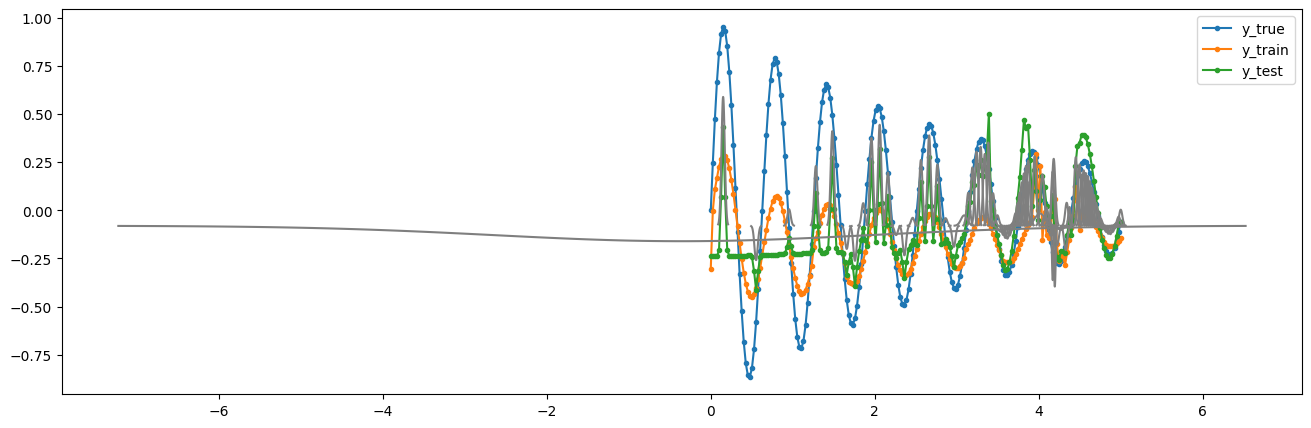

In [4]:
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(dataset["x"], dataset["y_true"], ".-", label="y_true")
ax.plot(dataset["x"], dataset["y_train"], ".-", label="y_train")
ax.plot(dataset["x"], y_test, ".-", label="y_test")
for i, n in enumerate(net._hidden_nodes):
    c, r = n.center, n.radius
    norm = stats.norm.pdf(np.linspace(c - 3 * r, c + 3 * r, 100), c, r)
    norm /= np.max(norm)
    ax.plot(
        np.linspace(c - 3 * r, c + 3 * r, 100),
        net._weights[0, 0] + net._weights[0, i] * norm,
        color="tab:gray",
    )
ax.legend()
plt.show()

### Damped Sine Wave - Time Serie

In [7]:
dataset = pd.DataFrame()
x, y_true = create_time_series(damped_sine_wave(np.linspace(0, 10, 205)), look_back=5)
dataset["x0"] = x[:, 0]
dataset["x1"] = x[:, 1]
dataset["x2"] = x[:, 2]
dataset["x3"] = x[:, 3]
dataset["x4"] = x[:, 4]
dataset["y_true"] = y_true
dataset["y_train"] = np.nan

net = Network(
    input_size=5,
    output_size=1,
    error_threshold=0.02,
    distance_threshold=0.2,
    learning_rate=0.1,
    overlap_factor=0.8,
    activation_threshold=0.01,
    pruning_window=150,
)

history = pd.DataFrame()
for epoch in tqdm(range(100)):
    # perform learning
    for i, row in dataset.iterrows():
        dataset.loc[i, "y_train"] = net.learning(
            x=np.array([row["x0"], row["x1"], row["x2"], row["x3"], row["x4"]]),
            y=np.array([row["y_true"]]),
        )

    # save history
    history = pd.concat(
        [
            history,
            pd.DataFrame(
                {
                    "d": [net._d_th],
                    "e": [net._e_th],
                    "n": [len(net._hidden_nodes)],
                    "mae": [mae(dataset["y_true"], dataset["y_train"])],
                    "rmse": [rmse(dataset["y_true"], dataset["y_train"])],
                    "mape": [mape(dataset["y_true"], dataset["y_train"])],
                    "smape": [smape(dataset["y_true"], dataset["y_train"])],
                }
            ),
        ],
        ignore_index=True,
    )

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Final number of neurons: 15
MAE: 0.0078 hPa
RMSE: 0.0124 hPa
SMAPE: 8.2042 %


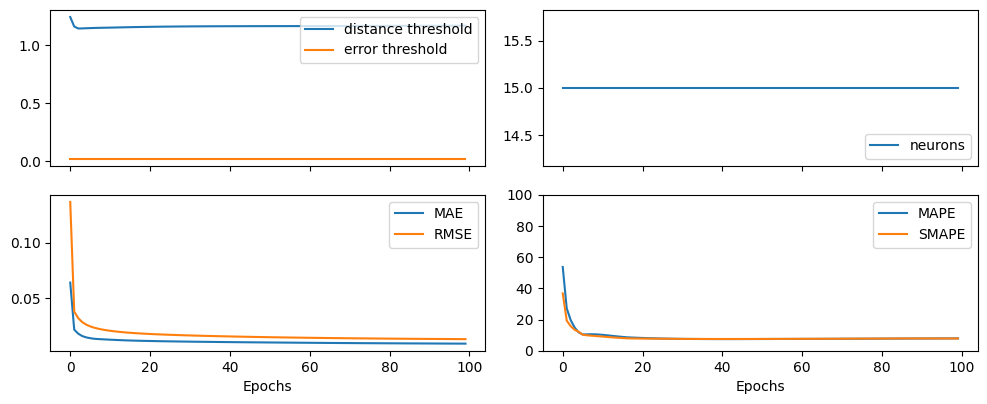

In [8]:
print("Final number of neurons:", len(net._hidden_nodes))

y_test = np.array(
    [
        net.inference(
            np.array(
                [row[1]["x0"], row[1]["x1"], row[1]["x2"], row[1]["x3"], row[1]["x4"]]
            )
        )
        for row in dataset.iterrows()
    ]
)
print_metrics(dataset["y_true"], y_test)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
fig.tight_layout()
ax1.plot(history.index, history["d"], label="distance threshold")
ax1.plot(history.index, history["e"], label="error threshold")
ax1.legend(loc="upper right")
ax2.plot(history.index, history["n"], label="neurons")
ax2.legend(loc="lower right")
ax3.plot(history.index, history["mae"], label="MAE")
ax3.plot(history.index, history["rmse"], label="RMSE")
ax3.set_xlabel("Epochs")
ax3.legend(loc="upper right")
ax4.plot(history.index, history["mape"], label="MAPE")
ax4.plot(history.index, history["smape"], label="SMAPE")
ax4.set_xlabel("Epochs")
ax4.set_ylim(0, 100)
ax4.legend(loc="upper right")
plt.show()

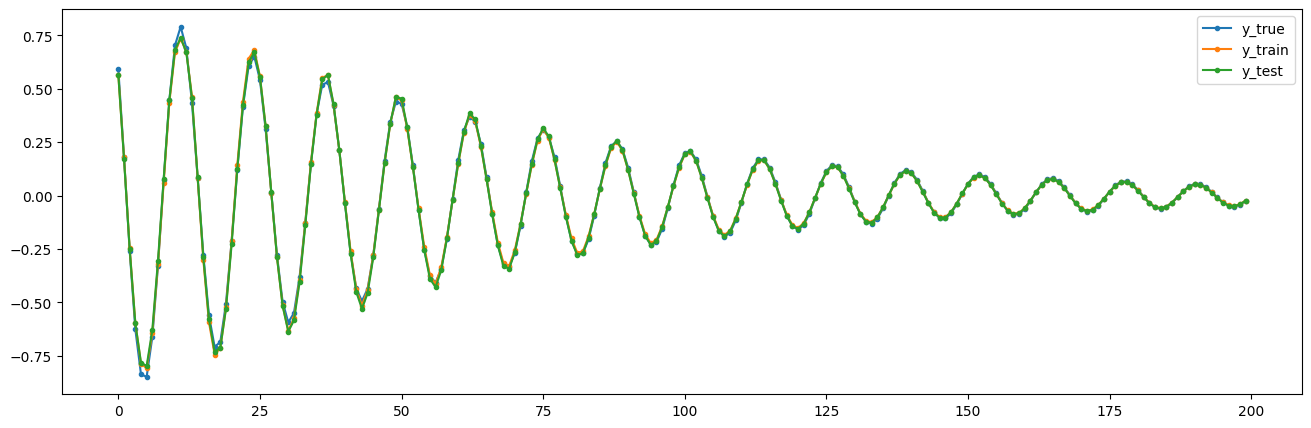

In [9]:
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(dataset.index, dataset["y_true"], ".-", label="y_true")
ax.plot(dataset.index, dataset["y_train"], ".-", label="y_train")
ax.plot(dataset.index, y_test, ".-", label="y_test")
ax.legend()
plt.show()

### Damped Sine Wave - Online Time Serie

In [10]:
TIME_STEPS = 150
SAMPLES_PER_TIME_STEP = 50
EPOCHS_PER_TIME_STEP = 25

dataset = pd.DataFrame()
x, y_true = create_time_series(
    damped_sine_wave(np.linspace(0, 10, TIME_STEPS + SAMPLES_PER_TIME_STEP + 5)),
    look_back=5,
)
dataset["x0"] = x[:, 0][:SAMPLES_PER_TIME_STEP]
dataset["x1"] = x[:, 1][:SAMPLES_PER_TIME_STEP]
dataset["x2"] = x[:, 2][:SAMPLES_PER_TIME_STEP]
dataset["x3"] = x[:, 3][:SAMPLES_PER_TIME_STEP]
dataset["x4"] = x[:, 4][:SAMPLES_PER_TIME_STEP]
dataset["y_true"] = y_true[:SAMPLES_PER_TIME_STEP]
dataset["y_train"] = np.nan

net = Network(
    input_size=5,
    output_size=1,
    error_threshold=0.02,
    distance_threshold=0.2,
    learning_rate=0.1,
    overlap_factor=0.8,
    activation_threshold=0.01,
    pruning_window=100,
)

history = pd.DataFrame()
bar = tqdm(range(TIME_STEPS))
for time_step in bar:
    # update dataset to include the next sample and remove the oldest one
    dataset["x0"] = x[:, 0][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["x1"] = x[:, 1][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["x2"] = x[:, 2][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["x3"] = x[:, 3][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["x4"] = x[:, 4][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["y_true"] = y_true[time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["y_train"] = np.nan

    for epoch in range(EPOCHS_PER_TIME_STEP):
        # perform learning
        for i, row in dataset.iterrows():
            dataset.loc[i, "y_train"] = net.learning(
                x=np.array([row["x0"], row["x1"], row["x2"], row["x3"], row["x4"]]),
                y=np.array([row["y_true"]]),
            )

        # save history
        history = pd.concat(
            [
                history,
                pd.DataFrame(
                    {
                        "d": [net._d_th],
                        "e": [net._e_th],
                        "n": [len(net._hidden_nodes)],
                        "mae": [mae(dataset["y_true"], dataset["y_train"])],
                        "rmse": [rmse(dataset["y_true"], dataset["y_train"])],
                        "mape": [mape(dataset["y_true"], dataset["y_train"])],
                        "smape": [smape(dataset["y_true"], dataset["y_train"])],
                    }
                ),
            ],
            ignore_index=True,
        )
        bar.set_postfix(
            {
                "RMSE": history["rmse"].iloc[-1],
                "SMAPE": history["smape"].iloc[-1],
            }
        )

100%|██████████| 150/150 [02:40<00:00,  1.07s/it, RMSE=3.26e-5, SMAPE=0.0991]


Final number of neurons: 17


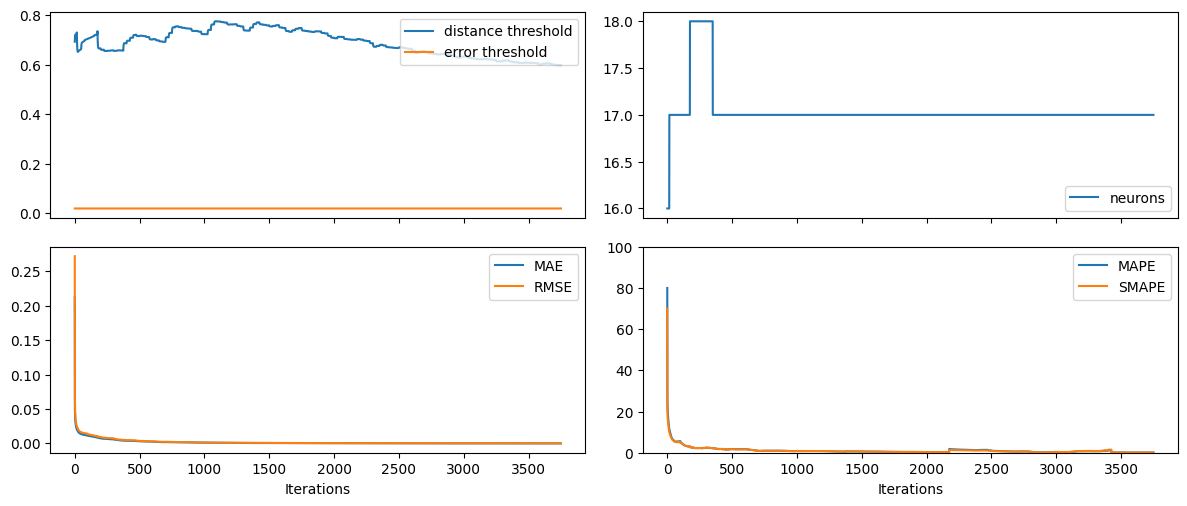

In [11]:
print("Final number of neurons:", len(net._hidden_nodes))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 5), sharex=True)
fig.tight_layout()
ax1.plot(history.index, history["d"], label="distance threshold")
ax1.plot(history.index, history["e"], label="error threshold")
ax1.legend(loc="upper right")
ax2.plot(history.index, history["n"], label="neurons")
ax2.legend(loc="lower right")
ax3.plot(history.index, history["mae"], label="MAE")
ax3.plot(history.index, history["rmse"], label="RMSE")
ax3.set_xlabel("Iterations")
ax3.legend(loc="upper right")
ax4.plot(history.index, history["mape"], label="MAPE")
ax4.plot(history.index, history["smape"], label="SMAPE")
ax4.set_xlabel("Iterations")
ax4.set_ylim(0, 100)
ax4.legend(loc="upper right")
plt.show()

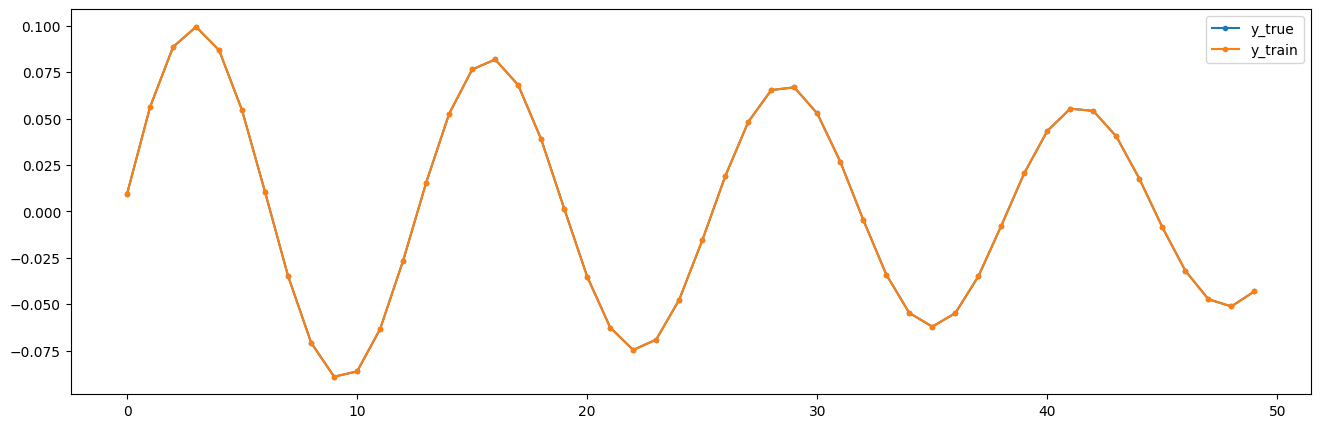

In [12]:
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(dataset.index, dataset["y_true"], ".-", label="y_true")
ax.plot(dataset.index, dataset["y_train"], ".-", label="y_train")
ax.legend()
plt.show()

### Mackey-Glass - Online Time Series

In [13]:
x, y_true = create_time_series(
    mackey_glass(length=2000, x0=1.0, sample=1.0), look_back=4, steps=6
)
x, y_true

(array([[0.55514857, 0.669179  , 1.00196575, 1.1734264 ],
        [0.54239221, 0.72937824, 1.04063813, 1.18772151],
        [0.54007328, 0.79188147, 1.07473232, 1.19673464],
        ...,
        [1.34171832, 1.12029894, 0.83860609, 0.58206256],
        [1.33175506, 1.06972463, 0.7942153 , 0.54428386],
        [1.30693833, 1.02086118, 0.74999277, 0.50862715]]),
 array([1.18399101, 1.17420141, 1.16548802, ..., 0.38854233, 0.36596774,
        0.34832144]))

In [17]:
TIME_STEPS = 400
SAMPLES_PER_TIME_STEP = 100
EPOCHS_PER_TIME_STEP = 1

dataset = pd.DataFrame()
dataset["x0"] = x[:, 0][:SAMPLES_PER_TIME_STEP]
dataset["x1"] = x[:, 1][:SAMPLES_PER_TIME_STEP]
dataset["x2"] = x[:, 2][:SAMPLES_PER_TIME_STEP]
dataset["x3"] = x[:, 3][:SAMPLES_PER_TIME_STEP]
dataset["y_true"] = y_true[:SAMPLES_PER_TIME_STEP]
dataset["y_train"] = np.nan

net = Network(
    input_size=4,
    output_size=1,
    error_threshold=0.05,
    distance_threshold=1.0,
    learning_rate=0.05,
    overlap_factor=0.8,
    activation_threshold=0.005,
    pruning_window=200,
)

history = pd.DataFrame()
bar = tqdm(range(0, TIME_STEPS))
for time_step in bar:
    # update dataset to include the next sample and remove the oldest one
    dataset["x0"] = x[:, 0][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["x1"] = x[:, 1][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["x2"] = x[:, 2][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["x3"] = x[:, 3][time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["y_true"] = y_true[time_step : (SAMPLES_PER_TIME_STEP + time_step)]
    dataset["y_train"] = np.nan

    for epoch in range(EPOCHS_PER_TIME_STEP):
        stats = np.zeros((len(dataset), 5))

        # perform learning
        for i, row in dataset.iterrows():
            dataset.loc[i, "y_train"] = net.learning(
                x=np.array([row["x0"], row["x1"], row["x2"], row["x3"]]),
                y=np.array([row["y_true"]]),
            )
            stats[i, 0] = net._d
            stats[i, 1] = np.linalg.norm(net._e)
            stats[i, 2] = net._d_th
            stats[i, 3] = net._e_th
            stats[i, 4] = len(net._hidden_nodes)

        # save history
        history = pd.concat(
            [
                history,
                pd.DataFrame(
                    {
                        "d": [stats[:, 0].mean()],
                        "e": [stats[:, 1].mean()],
                        "d_th": [stats[:, 2].mean()],
                        "e_th": [stats[:, 3].mean()],
                        "n": [stats[:, 4].mean()],
                        "mae": [mae(dataset["y_true"], dataset["y_train"])],
                        "rmse": [rmse(dataset["y_true"], dataset["y_train"])],
                        "mape": [mape(dataset["y_true"], dataset["y_train"])],
                        "smape": [smape(dataset["y_true"], dataset["y_train"])],
                    }
                ),
            ],
            ignore_index=True,
        )
        bar.set_postfix(
            {
                "RMSE": history["rmse"].iloc[-1],
                "SMAPE": history["smape"].iloc[-1],
            }
        )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:46<00:00,  8.56it/s, RMSE=0.0125, SMAPE=1.17]  


Final number of neurons: 18


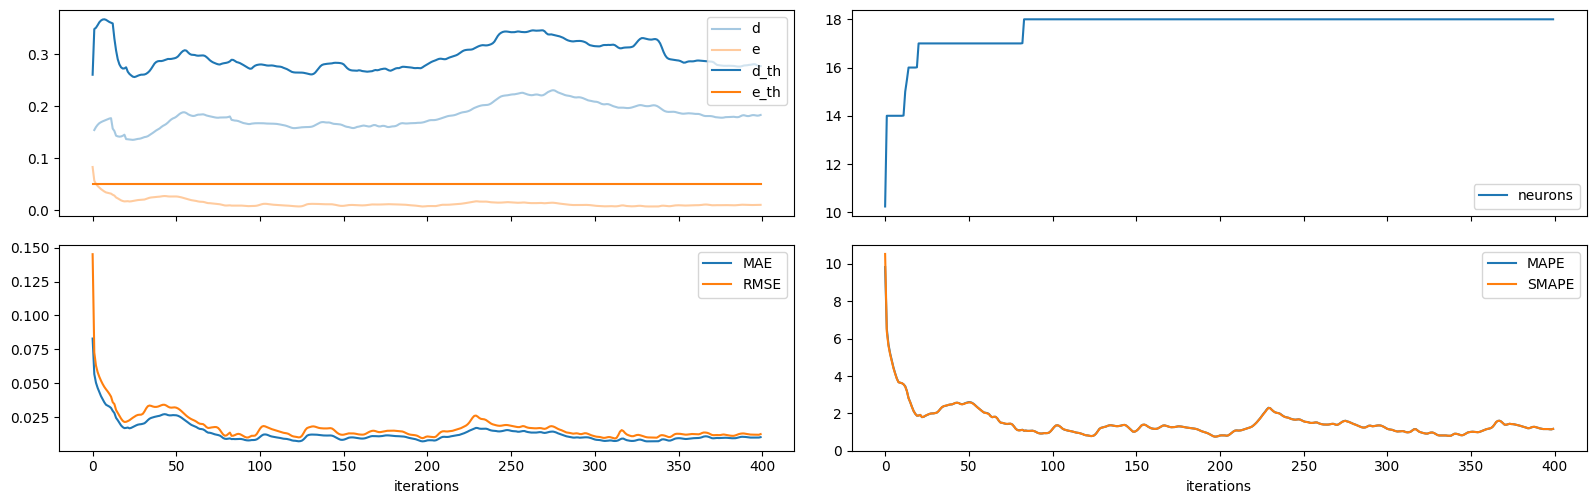

In [19]:
print("Final number of neurons:", len(net._hidden_nodes))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 5), sharex=True)
fig.tight_layout()
ax1.plot(history.index, history["d"], label="d", color="tab:blue", alpha=0.4)
ax1.plot(history.index, history["e"], label="e", color="tab:orange", alpha=0.4)
ax1.plot(history.index, history["d_th"], label="d_th", color="tab:blue")
ax1.plot(history.index, history["e_th"], label="e_th", color="tab:orange")
ax1.legend(loc="upper right")
ax2.plot(history.index, history["n"], label="neurons")
ax2.legend(loc="lower right")
ax3.plot(history.index, history["mae"], label="MAE")
ax3.plot(history.index, history["rmse"], label="RMSE")
ax3.set_xlabel("iterations")
ax3.legend(loc="upper right")
ax4.plot(history.index, history["mape"], label="MAPE")
ax4.plot(history.index, history["smape"], label="SMAPE")
ax4.set_xlabel("iterations")
ax4.set_ylim(0)
ax4.legend(loc="upper right")
plt.show()

MAE: 0.0420 hPa
RMSE: 0.0524 hPa
SMAPE: 4.9723 %


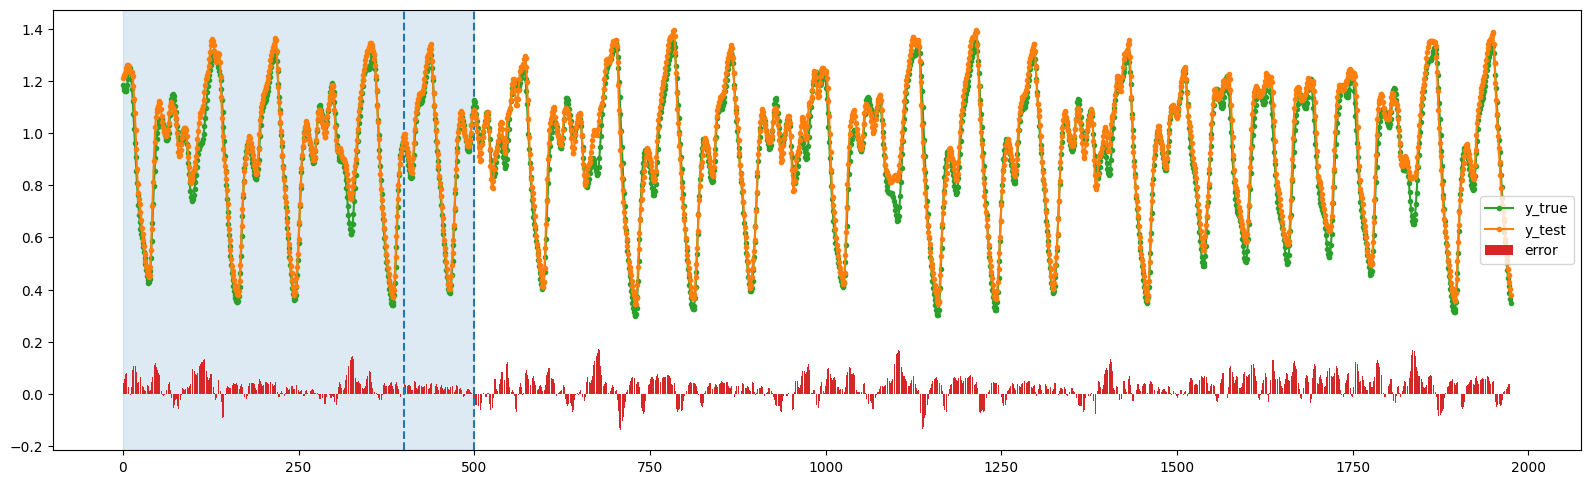

In [20]:
y_test = np.array([net.inference(np.array([r[0], r[1], r[2], r[3]]))[0] for r in x])

print_metrics(y_true, y_test)

fig, ax = plt.subplots(figsize=(16, 5))
fig.tight_layout()
ax.axvspan(0, TIME_STEPS + SAMPLES_PER_TIME_STEP, alpha=0.15, color="tab:blue")
ax.axvline(x=TIME_STEPS, color="tab:blue", linestyle="--")
ax.axvline(x=TIME_STEPS + SAMPLES_PER_TIME_STEP, color="tab:blue", linestyle="--")
ax.plot(range(len(y_true)), y_true, ".-", color="tab:green", label="y_true")
ax.plot(range(len(y_test)), y_test, ".-", color="tab:orange", label="y_test")
ax.bar(range(len(y_test)), y_test - y_true, color="tab:red", label="error")
ax.legend()
plt.show()

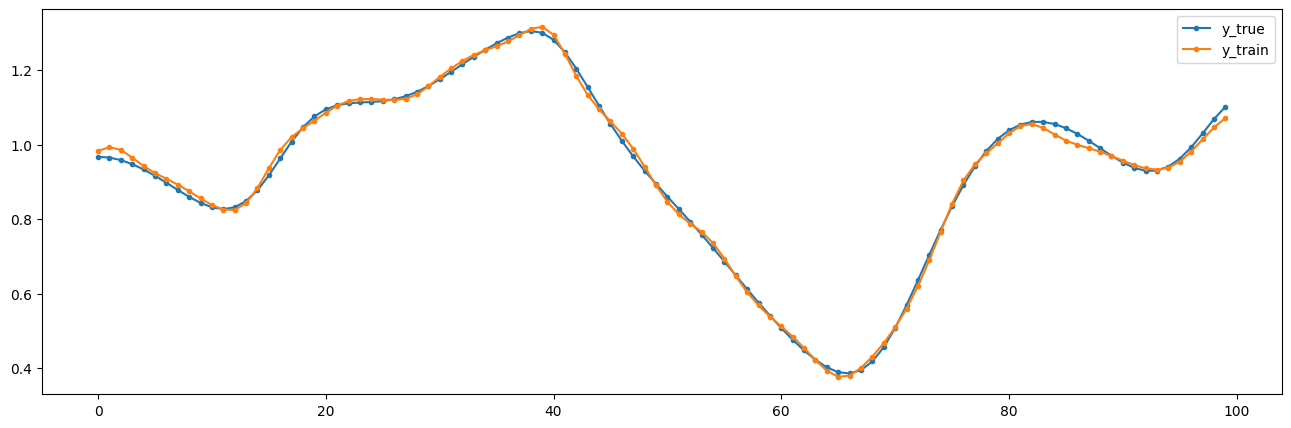

In [21]:
_, ax = plt.subplots(figsize=(16, 5))
ax.plot(dataset.index, dataset["y_true"], ".-", label="y_true")
ax.plot(dataset.index, dataset["y_train"], ".-", label="y_train")
ax.legend()
plt.show()

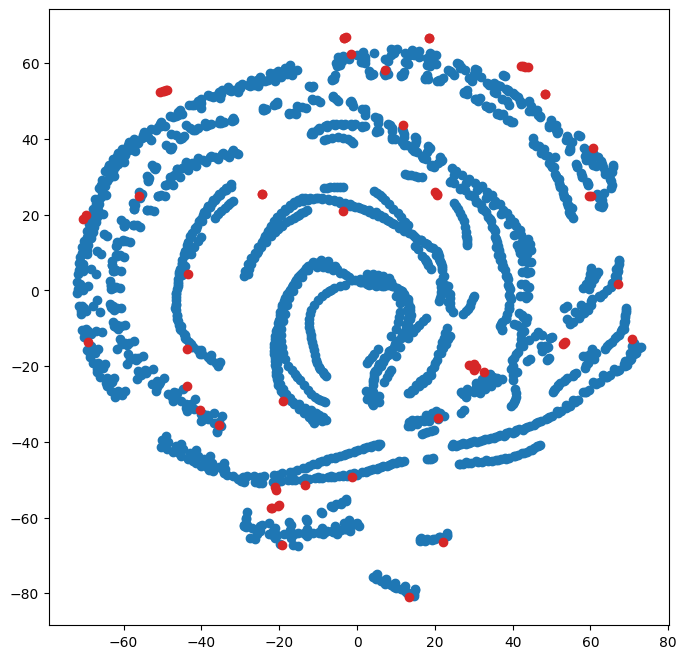

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
centers = np.array([n.center for n in net._hidden_nodes])
tsne_points = tsne.fit_transform(np.concatenate((x, centers), axis=0))

_, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    tsne_points[: -len(centers), 0], tsne_points[: -len(centers), 1], color="tab:blue"
)
ax.scatter(
    tsne_points[-len(centers) :, 0], tsne_points[-len(centers) :, 1], color="tab:red"
)
plt.show()